In [1]:
from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds
from tools.utils import set_seed
import numpy as np

set_seed(1234)

2023-07-01 20:25:56.221311: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-01 20:25:56.249647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 20:25:56.658010: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def test_dataset(name, path, *args, **kwargs):
    ds = make_sigmod_ds(name, *args, **kwargs)
    ds.load(path)
    print(ds.get_data().shape)
    print(ds.get_labels().shape)
    splitted_ds = ds.split_train_val_test(0.8, 0.1)
    print(ds.get_split_indecies()[0].shape)
    print(len(np.unique(ds.get_split_indecies()[0])))
    print(len(splitted_ds.train.labels))
    print(len(splitted_ds.val.labels))
    print(len(splitted_ds.test.labels))
    print(ds.get_modulations())
    snrs = ds.get_snrs()
    print(snrs, min(snrs), max(snrs))

In [3]:
# test_dataset("radioml_2016", "data/radioml_2016/RML2016.10a_dict.pkl")
# test_dataset(
#     "matlab_v2", "data/simc_v2_30k_fpm_0_30_snr/", frames_per_modulation=30_000, snrs=range(0, 30)
# )

In [4]:
radioml_ds = make_sigmod_ds("radioml_2016")
radioml_ds.load("data/radioml_2016/RML2016.10a_dict.pkl")

In [11]:
from models.fabric import make_sigmod_model, ConvolutionConfiguration

cnn_v1_configuration = ConvolutionConfiguration(
    input_shape=(1, 128, 2),
    n_classes=len(radioml_ds.get_modulations()),
    output_channels=[32, 48, 64, 96, 128, 192],
    kernel_sizes=[8, 8, 8, 8, 8, 8],
    paddings=["same", "same", "same", "same", "same", "same"],
    max_pool_sizes=[1, 1, 2, 1, 2, 1],
    max_pool_strides=[1, 1, 2, 1, 2, 1],
    avg_size=32,
    dense_sizes=[],
)

model = make_sigmod_model("cnn_1d_v1", cnn_v1_configuration)

model.summary()
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)
print(splitted_radioml_ds.train.data[0].shape)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 128, 2)]       0         
                                                                 
 CNN0_ (Conv2D)              (None, 1, 128, 32)        544       
                                                                 
 MAX_POOL_0_ (MaxPooling2D)  (None, 1, 128, 32)        0         
                                                                 
 BN0_ (CustomBatchNorm)      (None, 1, 128, 32)        128       
                                                                 
 CNN_REL0_ (ReLU)            (None, 1, 128, 32)        0         
                                                                 
 CNN1_ (Conv2D)              (None, 1, 128, 48)        12336     
                                                                 
 MAX_POOL_1_ (MaxPooling2D)  (None, 1, 128, 48)        0   

In [12]:
# from models.fabric import make_sigmod_model, EncoderTransformerConfiguration, EncoderLayerConfiguration

# enc_v1_configuration = EncoderTransformerConfiguration(
#     input_shape=(128, 2),
#     n_classes=len(radioml_ds.get_modulations()),
    
#     cnn_output_channels=[32],
#     cnn_kernel_sizes=[8],
#     cnn_paddings=["same"],
    
#     encoder_layer=EncoderLayerConfiguration(
#         h=4,
#         d_k=32,
#         d_v=32,
#         d_model=32,
#         d_ff=128,
#         n=4,
#     ),
    
#     avg_size=32,
#     dense_sizes=[128],
# )

# model = make_sigmod_model("encoder_transformer_1d_v1", enc_v1_configuration)
# model.summary()
# splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)
# print(splitted_radioml_ds.train.data[0].shape)

In [13]:
# TODO: remove this inconsistency
# splitted_radioml_ds.train.data = np.squeeze(splitted_radioml_ds.train.data)
# splitted_radioml_ds.val.data = np.squeeze(splitted_radioml_ds.val.data)
# splitted_radioml_ds.test.data = np.squeeze(splitted_radioml_ds.test.data)

# print(splitted_radioml_ds.train.data.shape)

In [14]:
import tensorflow as tf

def step_decay(epoch):
    lrate = 0.001
    factor = epoch // 8
    lrate /= 10**factor
    return lrate


lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
    # optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

# N_EPOCHS = 16
N_EPOCHS = 6
BATCH_SIZE = 256
# N_EPOCHS = 5
# BATCH_SIZE = 128

h = model.fit(
    splitted_radioml_ds.train.data,
    splitted_radioml_ds.train.labels,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
    callbacks=[lrate]
)


Epoch 1/6


2023-07-01 20:26:34.571821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-01 20:26:35.527506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-01 20:26:35.530727: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x32bdcbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-01 20:26:35.530752: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2023-07-01 20:26:35.534421: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-01 20:26:35.623525: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetim

688/688 [==============================] - 12s 12ms/step - loss: 1.8283 - accuracy: 0.3158 - val_loss: 1.5685 - val_accuracy: 0.4158 - lr: 0.0010
Epoch 2/6
688/688 [==============================] - 7s 10ms/step - loss: 1.4627 - accuracy: 0.4470 - val_loss: 1.3764 - val_accuracy: 0.4733 - lr: 0.0010
Epoch 3/6
688/688 [==============================] - 7s 10ms/step - loss: 1.3084 - accuracy: 0.4970 - val_loss: 1.3223 - val_accuracy: 0.4975 - lr: 0.0010
Epoch 4/6
688/688 [==============================] - 7s 10ms/step - loss: 1.2472 - accuracy: 0.5245 - val_loss: 1.2534 - val_accuracy: 0.5297 - lr: 0.0010
Epoch 5/6
688/688 [==============================] - 7s 10ms/step - loss: 1.2156 - accuracy: 0.5391 - val_loss: 1.2285 - val_accuracy: 0.5390 - lr: 0.0010
Epoch 6/6
688/688 [==============================] - 7s 10ms/step - loss: 1.1889 - accuracy: 0.5495 - val_loss: 1.1802 - val_accuracy: 0.5534 - lr: 0.0010


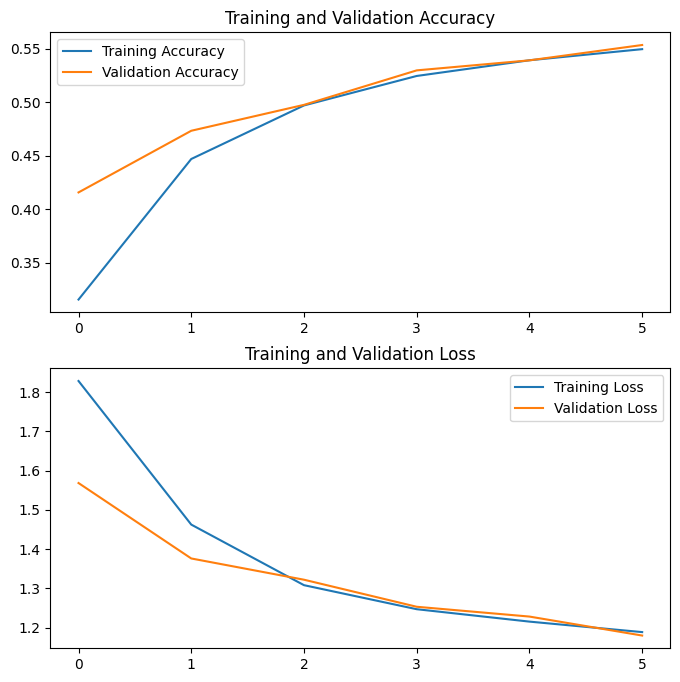

In [16]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_train
plot_train(h.history)

688/688 [==============================] - 1s 2ms/step
Overall test accuracy: {'Overall': 0.5562727272727273}
8PSK test accuracy: 0.5280373831775701
AM-DSB test accuracy: 0.6746268656716418
AM-SSB test accuracy: 0.9052478134110787
BPSK test accuracy: 0.6056676272814602
CPFSK test accuracy: 0.6001034661148474
GFSK test accuracy: 0.6329866270430906
PAM4 test accuracy: 0.6646433990895296
QAM16 test accuracy: 0.12331502745881179
QAM64 test accuracy: 0.652784746613146
QPSK test accuracy: 0.47462839569451565
WBFM test accuracy: 0.25146484375
Confusion matrix:
[[1017   31  583   43   30   16   21   52   55   76    2]
 [   4 1356  437    7    7   48    2    6    0    3  140]
 [  17   79 1863   33   16    9    4    6    0   21   10]
 [  33   20  618 1261   16    8   67   18    9   24    8]
 [  49   36  565   24 1160   13    9   15   18   35    9]
 [   7   71  537   20   34 1278    9    4    1    8   50]
 [  13   27  460   85    8    8 1314   22   11   19   10]
 [ 124   18  354   46   24   16   

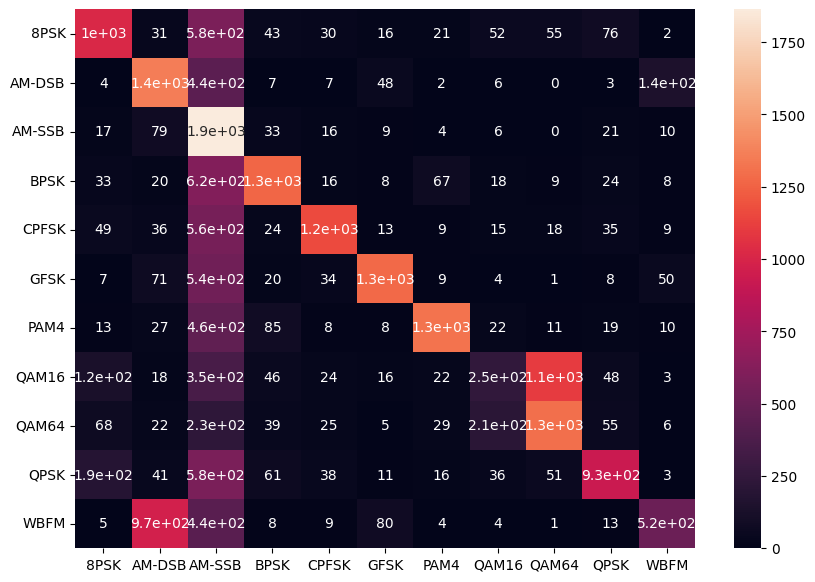

In [17]:
cm, accs = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

In [22]:
snr_to_acc = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)

SNR: -20 -- Overall test accuracy: 0.11150131694468832
SNR: -18 -- Overall test accuracy: 0.10304659498207885
SNR: -16 -- Overall test accuracy: 0.10849056603773585
SNR: -14 -- Overall test accuracy: 0.1076923076923077
SNR: -12 -- Overall test accuracy: 0.1585253456221198
SNR: -10 -- Overall test accuracy: 0.2530009233610342
SNR: -8 -- Overall test accuracy: 0.35475352112676056
SNR: -6 -- Overall test accuracy: 0.4753946146703807
SNR: -4 -- Overall test accuracy: 0.6198934280639432
SNR: -2 -- Overall test accuracy: 0.7112676056338029
SNR: 0 -- Overall test accuracy: 0.7619485294117647
SNR: 2 -- Overall test accuracy: 0.8102189781021898
SNR: 4 -- Overall test accuracy: 0.8167441860465117
SNR: 6 -- Overall test accuracy: 0.8058771148708815
SNR: 8 -- Overall test accuracy: 0.8225068618481244
SNR: 10 -- Overall test accuracy: 0.8315018315018315
SNR: 12 -- Overall test accuracy: 0.8269927536231884
SNR: 14 -- Overall test accuracy: 0.8322981366459627
SNR: 16 -- Overall test accuracy: 0.80605

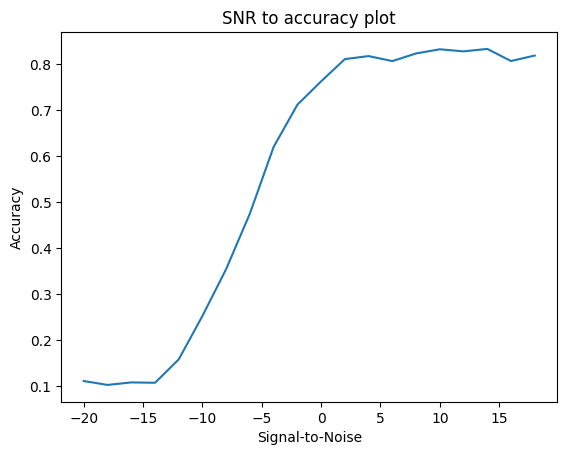

In [30]:
import matplotlib.pyplot as plt
xs = sorted(list(snr_to_acc.keys()))
ys = list(snr_to_acc.values())
ys = sorted(ys, key=lambda y: xs[ys.index(y)])
# plt.figure(figsize=(8, 8))
plt.plot(xs, ys)
plt.title("SNR to accuracy plot")
plt.ylabel("Accuracy")
plt.xlabel("Signal-to-Noise")
plt.show()